In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import glob
import os
from pathlib import Path  
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import matplotlib as matplotlib
import hashlib

In [2]:
df = pd.concat(map(pd.read_csv, glob.glob(
    os.path.join('/Users/cerenyikilmaz/Desktop/RFM_Analyse/dataset', "*2021.csv"))))

In [3]:
#dropping null values

df = df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)

In [4]:
# data-type changes

df["customer_id"] = df["customer_id"].astype('str')
df["item_id"] = df["item_id"].astype('str')
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [5]:
df['customer_id']=df['customer_id'].str[:-2]

In [6]:
# dropping price value later than 0

index_names = df[ df['unit_price'] <= 0 ].index
df.drop(index_names, inplace = True)

In [7]:
# While examining the dataset, we see that there are too many products named “Uçak Bileti”, 
# but we see that these products contain illogical values in terms of unit_price. 
# For this reason, we clear the "Uçak Bileti" products from the data set to avoid data inconsistency.


index_names = df[ df['item_name'] == "Uçak Bileti" ].index
df.drop(index_names, inplace = True)

In [8]:
# I use the customer_id and purchase_time variables for this. 
# If there are values for a customer_id with exactly the same purchase_time, 
# the invoice number generated for them will be the same because they were purchased in the same cart.

df = df.copy()
key_combination = ['customer_id', 'purchase_time']
df['invoice_number'] = list(map(lambda x: hashlib.sha1('-'.join([str(col_value) for col_value in x])
                                                      .encode('utf-8')).hexdigest(), df[key_combination].values))

In [9]:
# How much money was spent per transaction
# I'm using the item_count and unit_price variables in my dataset to find this out.

df["total_price"] = df["item_count"] * df["unit_price"]

In [10]:
df['purchase_date'] = pd.DatetimeIndex(df['purchase_time']).date

In [11]:
df.head()

,customer_id,item_id,item_name,unit_price,item_count,purchase_time,invoice_number,total_price,purchase_date
0,6359890,386012549,"Mekoraf 2,5 Metre Çelik Raf Profil 40x40 1,5 m...",105.90,1,2021-12-31 23:59:03,8ee5aa0bf0fb31da5c72025b259fff1883a3ffe0,105.90,2021-12-31
1,14996678,474835415,Intel Core i9-10980XE Extreme Edition 3 GHz LG...,17250.00,1,2021-12-31 23:58:57,b65e6fb1c36ef1bf3aa26874927c2677627d236a,17250.00,2021-12-31
2,11479470,505465829,7 Cm Yükseklikte Aralıklı Tahtalardan Yüksek M...,10.22,1,2021-12-31 23:58:25,d04b373e7d157188f8200350d77f54d6b9dc4f5c,10.22,2021-12-31
3,8478960,520605618,Riddex Elektronik Fare ve Haşere Kovucu Cihaz,34.99,1,2021-12-31 23:58:13,7d8efca99333b32f09d95f0c4e45b1bb920fb220,34.99,2021-12-31
4,27426979,504242650,Razer Gold 25 TL,25.00,1,2021-12-31 23:57:12,a71f62a5f8a8407fedb8da3145408c47c6874cc1,25.00,2021-12-31


In [12]:
now = dt.date(2022,1,1)
print(now)

2022-01-01


## Recency

In [13]:
recency_df = df.groupby(by='customer_id', as_index=False)['purchase_date'].max()
recency_df.columns = ['customer_id','last_purchase_date']
recency_df.head()

,customer_id,last_purchase_date
0,10000000,2021-12-09
1,10000001,2021-07-01
2,10000021,2021-12-27
3,10000038,2021-02-07
4,10000043,2021-10-30


In [14]:
recency_df['recency'] = recency_df['last_purchase_date'].apply(lambda x: (now - x).days)

In [15]:
recency_df.drop('last_purchase_date',axis=1,inplace=True)

In [16]:
recency_df.head(5)

,customer_id,recency
0,10000000,23
1,10000001,184
2,10000021,5
3,10000038,328
4,10000043,63


## Frequency

In [17]:
df_copy = df

frequency_df = df_copy.groupby(by=['customer_id'], as_index=False)['invoice_number'].count()
frequency_df.columns = ['customer_id','frequency']
frequency_df.head(5)

,customer_id,frequency
0,10000000,1
1,10000001,7
2,10000021,5
3,10000038,2
4,10000043,4


## Monetary

In [18]:
monetary_df = df.groupby(by='customer_id',as_index=False).agg({'total_price': 'sum'})
monetary_df.columns = ['customer_id','monetary']
monetary_df.head(5)

,customer_id,monetary
0,10000000,200.00
1,10000001,416.37
2,10000021,395.45
3,10000038,89.80
4,10000043,119.64


## RFM Scoring

In [19]:
temp_df = recency_df.merge(frequency_df,on='customer_id')
temp_df.head()

,customer_id,recency,frequency
0,10000000,23,1
1,10000001,184,7
2,10000021,5,5
3,10000038,328,2
4,10000043,63,4


In [20]:
rfm_df = temp_df.merge(monetary_df,on='customer_id')
rfm_df.set_index('customer_id',inplace=True)
rfm_df.head()

,recency,frequency,monetary
customer_id,,,
10000000,23,1,200.00
10000001,184,7,416.37
10000021,5,5,395.45
10000038,328,2,89.80
10000043,63,4,119.64


In [21]:
rfm_df["RecencyScore"] = pd.qcut(rfm_df['recency'], 5, labels = [5, 4, 3, 2, 1])
rfm_df["FrequencyScore"] = pd.qcut(rfm_df['frequency'].rank(method = "first"), 5, labels = [1,2,3,4,5])
rfm_df["MonetaryScore"] = pd.qcut(rfm_df['monetary'], 5, labels = [1,2,3,4,5])

In [22]:
rfm_df.head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore
customer_id,,,,,,
10000000,23,1,200.00,5,1,2
10000001,184,7,416.37,2,4,3
10000021,5,5,395.45,5,4,3
10000038,328,2,89.80,1,2,1
10000043,63,4,119.64,4,4,2


In [23]:
rfm_df["RFM_Score"] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str) + rfm_df['MonetaryScore'].astype(str)
rfm_df.head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
customer_id,,,,,,,
10000000,23,1,200.00,5,1,2,512
10000001,184,7,416.37,2,4,3,243
10000021,5,5,395.45,5,4,3,543
10000038,328,2,89.80,1,2,1,121
10000043,63,4,119.64,4,4,2,442


In [24]:
rfm_df[rfm_df["RFM_Score"] == "555"].head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
customer_id,,,,,,,
10000352,21,16,2059.44,5,5,5,555
10000530,22,10,1824.94,5,5,5,555
10000625,36,8,17342.02,5,5,5,555
10000638,14,9,2684.45,5,5,5,555
10000648,38,13,10927.56,5,5,5,555


In [25]:
rfm_df[rfm_df["RFM_Score"] == "111"].head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score
customer_id,,,,,,,
10000271,265,1,59.90,1,1,1,111
10000320,286,1,21.00,1,1,1,111
10000410,330,1,66.95,1,1,1,111
10000448,313,1,79.65,1,1,1,111
1000052,322,1,22.95,1,1,1,111


In [26]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [27]:
rfm_df['Segment'] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(seg_map, regex=True)
rfm_df.head()

,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Segment
customer_id,,,,,,,,
10000000,23,1,200.00,5,1,2,512,New Customers
10000001,184,7,416.37,2,4,3,243,At Risk
10000021,5,5,395.45,5,4,3,543,Champions
10000038,328,2,89.80,1,2,1,121,Hibernating
10000043,63,4,119.64,4,4,2,442,Loyal Customers


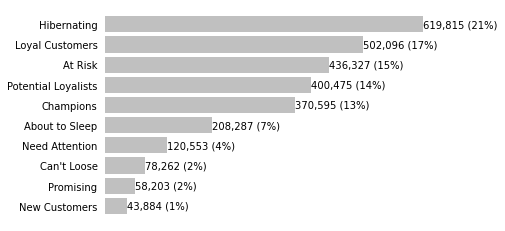

In [28]:
segments_counts = rfm_df['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Can\'t loose']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [29]:
rfm_df[["Segment", "recency","frequency","monetary"]].groupby("Segment").agg(["mean","count","max"]).head(20)

recency               frequency                \
                           mean   count  max       mean   count   max   
Segment                                                                 
About to Sleep       127.477173  208287  176   1.149880  208287     2   
At Risk              259.651154  436327  365   3.255565  436327     7   
Can't Loose          240.842222   78262  365  12.056669   78262   322   
Champions             17.646714  370595   38  17.045119  370595  1013   
Hibernating          276.282605  619815  365   1.120423  619815     2   
Loyal Customers       90.081785  502096  176   9.644610  502096   559   
Need Attention       126.397626  120553  176   2.400430  120553     3   
New Customers         19.766931   43884   38   1.000000   43884     1   
Potential Loyalists   46.614730  400475   86   1.795902  400475     3   
Promising             63.197138   58203   86   1.000000   58203     1   

                        monetary                       
                            mean   count          max  
Segment                                                
About to Sleep        553.054367  208287   3968000.00  
At Risk               915.965273  436327   4026279.16  
Can't Loose          2665.852604   78262   5048955.44  
Champions            6713.007881  370595  33884465.85  
Hibernating           437.872125  619815    558625.00  
Loyal Customers      3022.967082  502096  11800915.55  
Need Attention        932.680750  120553   5282900.92  
New Customers         810.744272   43884    934500.00  
Potential Loyalists   931.231382  400475   3796739.60  
Promising             642.729862   58203    601975.00

In [30]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_df.groupby('Segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                    recency frequency monetary        
                       mean      mean     mean   count
Segment                                               
About to Sleep        127.5       1.1    553.1  208287
At Risk               259.7       3.3    916.0  436327
Can't Loose           240.8      12.1   2665.9   78262
Champions              17.6      17.0   6713.0  370595
Hibernating           276.3       1.1    437.9  619815
Loyal Customers        90.1       9.6   3023.0  502096
Need Attention        126.4       2.4    932.7  120553
New Customers          19.8       1.0    810.7   43884
Potential Loyalists    46.6       1.8    931.2  400475
Promising              63.2       1.0    642.7   58203


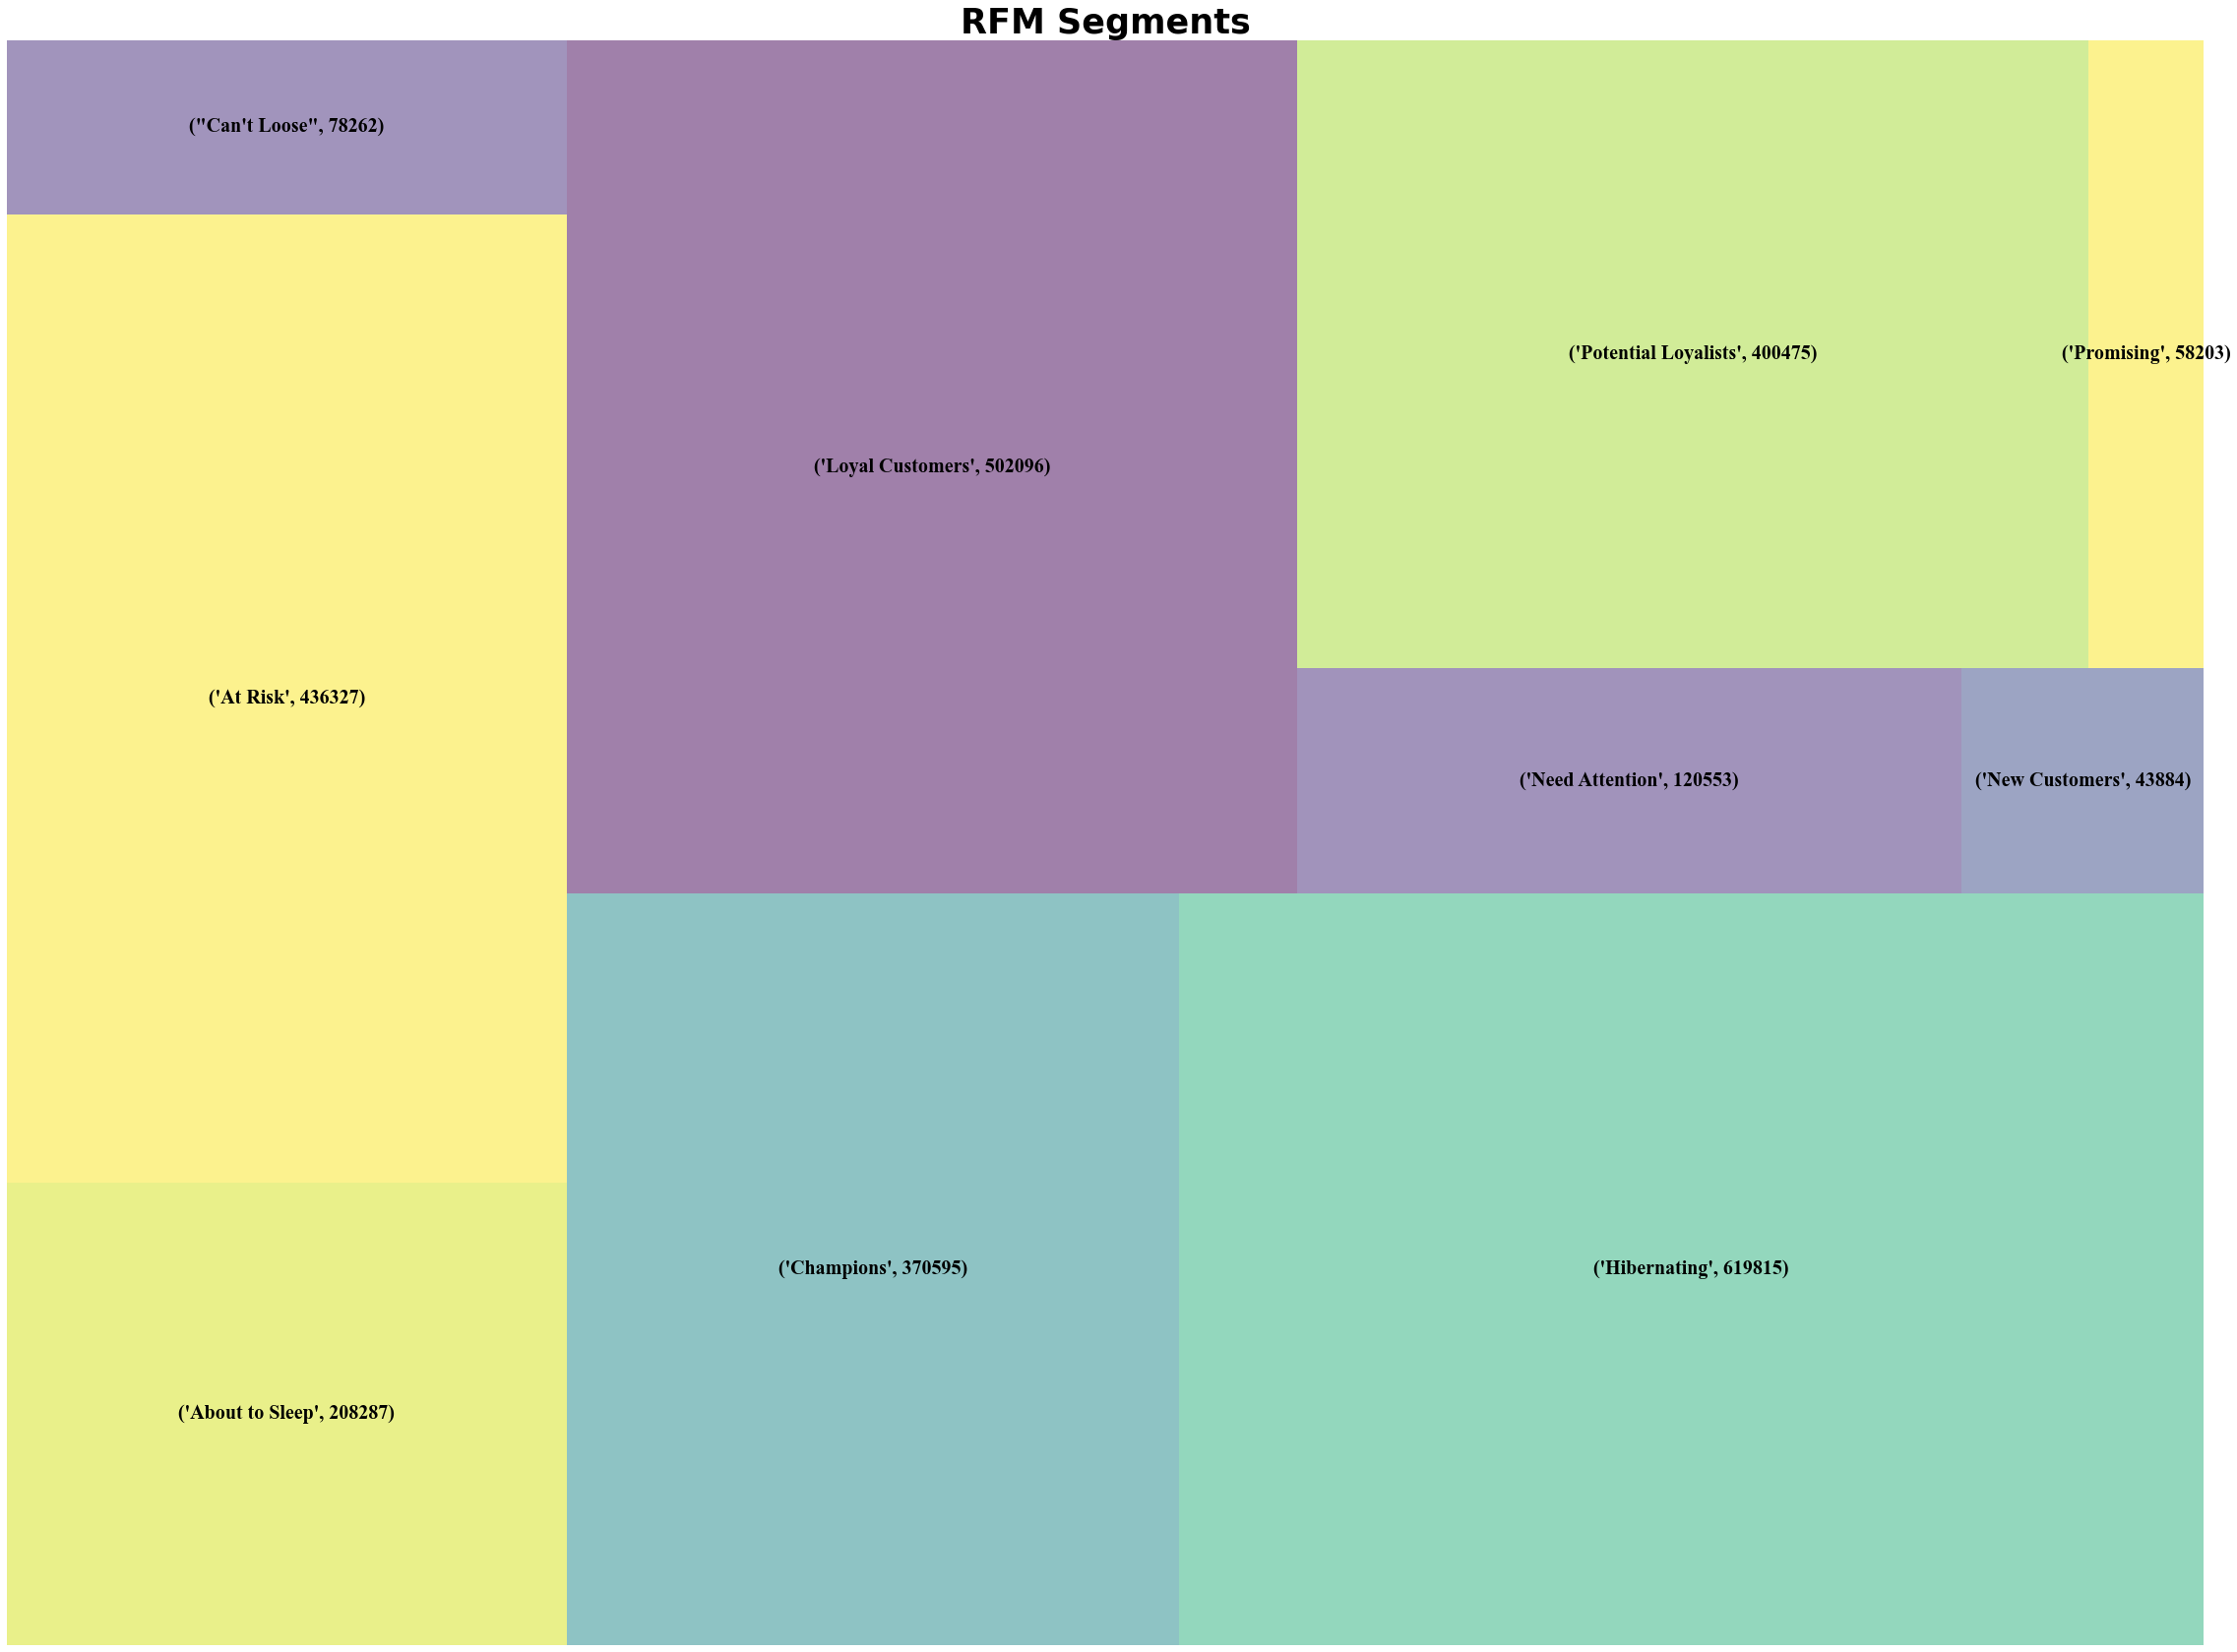

In [31]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

#Create our plot and resize it.

origin_counts = rfm_df.groupby('Segment').size().reset_index(name='counts')
labels= list(zip(origin_counts.Segment, origin_counts.counts))

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(40, 30)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=labels, alpha=.51,
              text_kwargs={'fontsize':20, 'fontname':"Times New Roman",'weight':'bold'})
plt.title("RFM Segments",fontsize=35,fontweight="bold")
plt.axis('off')
plt.show()